# Supplementary data for "The Life Cycle of Structural Biology Data"
This paper was submitted to the Data Science Journal.


## New Entries Released Each Year

In [1]:
PDBE_SOLR_URL = "http://www.ebi.ac.uk/pdbe/search/pdb"                 
# or https://www.ebi.ac.uk/pdbe/search/pdb/select?rows=0&q=status:REL&wt=json

from mysolr import Solr
solr = Solr(PDBE_SOLR_URL, version=4)

response = solr.search(**{
        "rows" : 0, # "fl" : "deposition_year", 
        "q" : 'status:REL',
        "facet" : "true", "facet.limit" : 1000000, "facet.mincount" : 1,
        "facet.field" : "deposition_year",
    }
)
from matplotlib import pyplot as plt

# skip current year, which is not yet complete
years = sorted( response.facets['facet_fields']['deposition_year'] )[0:-1]

fig = plt.figure()
plt.yscale('log')
plt.ylabel('PDB entries released')
plt.plot(years, [ response.facets['facet_fields']['deposition_year'][year] for year in years])
plt.xticks(['1980', '1990', '2000', '2010'])
fig.autofmt_xdate()
plt.show()

<Figure size 640x480 with 1 Axes>

## Complexes by year
If an entry referes to more than one macromolecule (i.e. is heteromeric) then the work is more challenging that research of a single protein.

There is another case. A project might target a homodimer, or more generally a homo-oligomer. For a homomeric protein structure, the PDB does not record the submitter's judgement of whether the contacts between the molecules are complexation of biological relevance, or merely crystal contacts. So we cannot distinguish targeted work on homo-complexes from other work on single species. We therefore report simply the proportion of projects that aim at one rather than many macromolecular species.

In [2]:
response = solr.search(**{
        "rows" : 0, "fl" : "deposition_year", 
        "q" : 'status:REL',
        'json.facet': """{
            deposition_year:{
                type:range,start:1971,end:2018,gap:1,field:deposition_year,limit:20,
                facet:{
                    facet1:{
                        type:terms, field:assembly_form,
                        facet:{
                            grouped_facet_count:\"unique(pdb_id)\"
                        }
                    },
                    grouped_depositionyear_count:\"unique(pdb_id)\"
                }
            }
        }"""
    }
)
# see an example of the response
response.raw_content['facets']['deposition_year']['buckets'][-4] 

{'val': 2014,
 'count': 19875,
 'grouped_depositionyear_count': 9365,
 'facet1': {'buckets': [{'val': 'hetero',
    'count': 12649,
    'grouped_facet_count': 2244},
   {'val': 'homo', 'count': 7121, 'grouped_facet_count': 7121}]}}

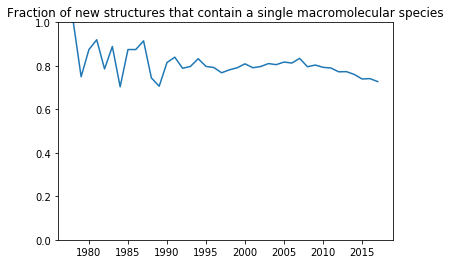

In [6]:
import pandas

rows = []
for bucket in response.raw_content['facets']['deposition_year']['buckets']:
    year = int(bucket['val'])
    hh = {'homo':0, 'hetero':0}
    if bucket['count'] > 0:
        total = bucket['grouped_depositionyear_count']
        for bbucket in bucket['facet1']['buckets']:
            hh[ bbucket['val'] ] = bbucket['grouped_facet_count']
            total = total - bbucket['grouped_facet_count']
        assert 0==total # sanity check
    rows.append([ year, hh['homo'], hh['hetero'] ])  

df = pandas.DataFrame(rows, columns=['year', 'homomeric', 'heteromeric']) 
df = df[df.year>1977]

plt.figure()
plt.plot(df.year, df.homomeric/(df.homomeric+df.heteromeric) )
plt.title('Fraction of new structures that contain a single macromolecular species')
plt.ylim([0, 1])
plt.show()

# New entries, by superkingdom

In [3]:
response = solr.search(**{
        "rows" : 0, "fl" : "deposition_year", 
        "q" : 'status:REL',
        'json.facet': """{
            deposition_year:{
                type:range,start:1971,end:2018,gap:1,field:deposition_year,limit:20,
                facet:{
                    facet1:{
                        type:terms, field:superkingdom,
                        facet:{
                            grouped_facet_count:\"unique(pdb_id)\"
                        }
                    },
                    grouped_depositionyear_count:\"unique(pdb_id)\"
                }
            }
        }"""
    }
)

# see an example of the response
response.raw_content['facets']['deposition_year']['buckets'][10] 

{'val': 1981,
 'count': 27,
 'grouped_depositionyear_count': 25,
 'facet1': {'buckets': [{'val': 'Eukaryota',
    'count': 21,
    'grouped_facet_count': 20},
   {'val': 'Bacteria', 'count': 3, 'grouped_facet_count': 3}]}}

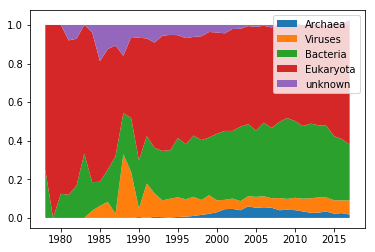

In [14]:
import pandas

values = ['Eukaryota', 'Archaea',  'Viruses', 'Bacteria', 'unknown' ]

def get_df(values):
    counts0 = {}
    for value in values:
        counts0[value] = 0
    rows = []
    for bucket in response.raw_content['facets']['deposition_year']['buckets']:
        year = int(bucket['val'])
        counts = dict(counts0)
        if bucket['count'] > 0:
            total = bucket['grouped_depositionyear_count']
            for bbucket in bucket['facet1']['buckets']:
                counts[ bbucket['val'] ] = bbucket['grouped_facet_count']
                total = total - bbucket['grouped_facet_count']
            counts['unknown'] = total
        rows.append([year]+[ counts[label] for label in counts0])  

    df = pandas.DataFrame(rows, columns=['year']+ list(counts0.keys()) )
    df = df[df.year>1977]
    df['total'] = df.Eukaryota+df.Archaea+df.Viruses+df.Bacteria+df.unknown
    return df

df = get_df(['Archaea',  'Viruses', 'Bacteria','Eukaryota',  'unknown' ])

def plot_df(df, values):
    plt.figure()
    running_total = pandas.Series([0]*len(df), index=df.index)
    for value in values:
        series = df[value] / df['total']
        plt.fill_between(df.year, running_total, running_total+series, label=value)
        running_total = running_total + series
    #archaea = df.Archaea/df['total']
    #viruses = df.Viruses/df['total']
    #bacteria = df.Bacteria/df['total']
    #eukaryota = df.Eukaryota/df['total']
    #plt.fill_between(df.year, archaea, archaea+viruses, label='Viruses' )
    #plt.fill_between(df.year, archaea+viruses, archaea+viruses+bacteria, label='Bacteria' )
    #plt.fill_between(df.year, archaea+viruses+bacteria, archaea+viruses+bacteria+eukaryota, label='Eukaryota' )
    #plt.fill_between(df.year, running_total, [1]*len(df), color='black', label='unknown' )
    plt.legend()
    plt.show()

plot_df(df, ['Archaea',  'Viruses', 'Bacteria','Eukaryota',  'unknown' ])

## Count entries by experiment type

In [12]:
response = solr.search(**{
    "rows" : 0, "fl" : "deposition_year", 
    "q" : 'status:REL',
    "facet" : "true", "facet.limit" : 10000000, "facet.mincount" : 1,
    "facet.field" : "experimental_method",
    "group" : "true", "group.facet" : "true",
    "group.field" : "pdb_id",
})

response.facets['facet_fields']['experimental_method']


OrderedDict([('X-ray diffraction', 127197),
             ('Solution NMR', 12203),
             ('Electron Microscopy', 2242),
             ('Neutron Diffraction', 142),
             ('Hybrid', 125),
             ('Solid-state NMR', 111),
             ('Electron crystallography', 106),
             ('X-ray solution scattering', 48),
             ('Fiber diffraction', 30),
             ('X-ray powder diffraction', 19),
             ('EPR', 8),
             ('Theoretical Model', 6),
             ('Infrared spectroscopy', 4),
             ('Fluorescence transfer', 1)])

## Count entries by year of deposition

Let us now facet on year of deposition and see the years in which an entry was deposited for carbonic anhydrases.